# Compare clustering results

This jupyter notebook (python) compares the clustering results between Phydelity, multi-state birth-death method by Barido-Sotani et al. and cutpoint-based method (WPGMA) results by Villandre et al. 

## Load libraries

In [1]:
from __future__ import division
import os 
import itertools 
import re
import numpy as np
import pandas as pd 
import subprocess 
import json
import csv
import numpy as np
import matplotlib
from sklearn.metrics import adjusted_rand_score as ari
from sklearn.metrics import mutual_info_score as mi_score
from matplotlib import pyplot as plt

## Input folders

In [2]:
simulation_trees_folder = './data/trees'
network_annotations_fname = './data/network_annotations.csv'
wpgma_cluster_results_folder = './data/wpgma'
msbd_cluster_results_folder = './data/MSBD'

## Functions to calculate clustering assessment metrics

We calculate several clustering assessment metrics against the underlying sexual contact network annotations: 
1. __Adjusted rand index__ ($ARI$): Accuracy of clustering results against sexual contact network 
2. __Purity__: Average extent clusters subtending only one class of network community  
3. __Modified gini index__ ($I_G$): Probability of a randomly selected sequence misclassified in the clustering results
4. __Normalised mutual information__ ($NMI$): Trade-off between quality of clustering and number of clusters

In [3]:
# calculate assessment metrics 
def get_metrics(labels_true, labels_pred):
    
    # sort and count ground truth labels within clusters
    pred_label_to_true_lab_count = {}
    for p, pred_label in enumerate(labels_pred):
        true_label = labels_true[p]
        try:
            pred_label_to_true_lab_count[pred_label][true_label] += 1
        except:
            try:
                pred_label_to_true_lab_count[pred_label][true_label] = 1
            except:
                pred_label_to_true_lab_count[pred_label] = {true_label:1}
    
    # generate confusion matrix 
    confusion_matrix = {}
    for pred_label in pred_label_to_true_lab_count.keys():
        
        for true_label in set(labels_true):
            try:
                count = pred_label_to_true_lab_count[pred_label][true_label]
            except:
                count = 0
            
            try:
                confusion_matrix[true_label].append(count)
            except:
                confusion_matrix[true_label] = [count]
    
    confusion_matrix = pd.DataFrame(confusion_matrix)
    
    # calculate purity using summation of max of each column (class) for each row (cluster) 
    purity = sum(confusion_matrix.max(axis=1))/len(labels_pred)
    
    # modified gini 
    # first, we determine which cluster is the "correct" cluster to class 
    maxc_to_t = {} # nested dictionary of cluster c that subtends the max proportion of class t(s) 
    for t in confusion_matrix:
        # total number of items of class t 
        total_t = sum(confusion_matrix[t])
        
        # get dictionary of cluster index c and the proportion of class t it subtends 
        c_to_tprop = {c:c_count/total_t for c, c_count in enumerate(confusion_matrix[t]) if c_count > 0}
        
        # get the maximum proportion of class t subtended among all clusters 
        max_tprop = max(c_to_tprop.values())
        
        for c, tprop in c_to_tprop.items(): 
            # if cluster c subtends the max. proportion of class t 
            if tprop == max_tprop: 
                try: 
                    maxc_to_t[c][t] = tprop
                except:
                    maxc_to_t[c] = {t:tprop}
    
    # now, we have to make sure that for each class t subtended by cluster c, it is also the largest by 
    # proportion within the cluster 
    t_to_maxc = {}
    for c, t_to_tprop in maxc_to_t.items():
        if len(t_to_tprop) == 1: # cluster only subtends 
            t = t_to_tprop.keys()[0]
            try:
                t_to_maxc[t][c] = tprop
            except: 
                t_to_maxc[t] = {c:tprop}
        else:
            total_counts_in_cluster = sum(confusion_matrix.iloc[c])
            t_to_cprop = {t:list(confusion_matrix[t])[c]/total_counts_in_cluster for t in t_to_tprop.keys()}
            max_cprop = max(t_to_cprop.values())
            
            for t, cprop in t_to_cprop.items():
                if cprop == max_cprop:
                    try:
                        t_to_maxc[t][c] = tprop
                    except: 
                        t_to_maxc[t] = {c:tprop}
    
    # if class t is equally divided across all clusters, then none of the cluster is a "correct" cluster to t 
    for t, c_to_tprop in t_to_maxc.items():
        if len(c_to_tprop) == len(set(labels_pred)) and len(set(c_to_tprop.values())) == 1:
            t_to_maxc[t] = {}
    
    # calculate modified gini
    gini_index = 0 
    for t in list(set(labels_true)):
        c_counts = list(confusion_matrix[t])
        # get proportion of class t among all tips clustered 
        p_t = sum(c_counts)/len(labels_true)
        
        try: 
            # for class t with a "correct" cluster identified 
            maxc_list = t_to_maxc[t].keys()
        except:
            # for class t without a "correct" cluster 
            gini_index += p_t
            continue 
        
        # get proportion of correctly classifed class t 
        p_correct = sum([(c_counts[c]/len(labels_true))/p_t for c in maxc_list])
        
        gini_index += p_t*(1-p_correct)
    
    return purity, gini_index
    
# calculate information entropy
def entropy(probability_distribution):
    return -sum([p * np.log(p) for p in probability_distribution])

## Parse for optimal cutpoint (WPGMA) clustering results 

In [4]:
# parse network annotations file 
fileindices_to_leaf_to_nanno = {}
with open(network_annotations_fname, 'rb') as fhandle: 
    for l, line in enumerate(csv.reader(fhandle)):
        if l == 0:
            continue
        network, weight_index, sim_index, leaf, n_anno = line 
        network = network.replace('"', '')
        try: 
            fileindices_to_leaf_to_nanno[(network, weight_index, sim_index)][leaf] = n_anno
        except:
            fileindices_to_leaf_to_nanno[(network, weight_index, sim_index)] = {leaf:n_anno}
            
# parse raw newick files 
fileindidces_to_msbd_clustering_results = {}
fileindidces_to_wpgma_clustering_results = {}
fileindices_to_size = {}

for tfname in os.listdir(simulation_trees_folder):
    network, weight_index, sim_index = re.search('([A-Z])_(\d+)_(\d+)\.nwk', tfname).group(1,2,3)
    
    # reference network annotations 
    tiplabel_to_rcluster = fileindices_to_leaf_to_nanno[(network, weight_index, sim_index)]
    
    # generate annotated (with network anno) newick tree files 
    treefhandle = open('{}/{}'.format(simulation_trees_folder, tfname)).readline()
    prev_end = 0
    annotated_tree = []
    number_of_leaves = 0
    for expr in re.finditer('(\(|,)(\d+):', treefhandle):
        annotated_tree.append(treefhandle[prev_end:expr.start()+1])
        
        leaf = expr.group(2)
        number_of_leaves += 1
        n_anno = tiplabel_to_rcluster[leaf]
        annotated_tree.append('{}_N{}'.format(leaf, n_anno))
        
        prev_end = expr.end() - 1
    annotated_tree.append(treefhandle[prev_end:])
    
    with open('./data/annotated_trees/annotated_{}_{}_{}.nwk'.format(network, weight_index, sim_index), 'w') as output:
        output.write(''.join(annotated_tree))
    fileindices_to_size[(network, weight_index, sim_index)] = number_of_leaves
    
    # get MSBD clustering results
    labels_true = []
    labels_pred = []
    with open('{}/{}_fast_{}_{}.csv'.format(msbd_cluster_results_folder, network, weight_index, sim_index), 'rb') as fhandle:
        for l, line in enumerate(csv.reader(fhandle)):
            if l == 0:
                continue 
            
            leaf, msbd_cluster, n_anno = line
            labels_true.append(n_anno)
            labels_pred.append(msbd_cluster)
    
    msbd_ari = ari(labels_true, labels_pred)
    msbd_mi = mi_score(labels_true, labels_pred)
    true_H_msbd = entropy([labels_true.count(lab) / len(labels_true) for lab in list(set(labels_true))])
    msbd_H = entropy([labels_pred.count(lab) / len(labels_pred) for lab in list(set(labels_pred))])
    #vi_msbd = msbd_H + true_H_msbd - (2*msbd_mi)
    vi_msbd = 2*msbd_mi/(msbd_H + true_H_msbd)
    
    msbd_tpr, msbd_fpr = get_metrics(labels_true, labels_pred)
    
    fileindidces_to_msbd_clustering_results[(network, weight_index, sim_index)] = (msbd_ari, vi_msbd, msbd_tpr, msbd_fpr)
    
    # get best cutpoint clustering results (WPGMA)
    # wpgma label 
    with open('{}/{}_{}_{}_wpgma.csv'.format(wpgma_cluster_results_folder, network, weight_index, sim_index), 'rb') as fhandle:
        tiplabel_to_cutpoint_to_wpgmacluster = {}
        for l, line in enumerate(csv.reader(fhandle)):
            if l == 0:
                cutpoint_to_index = {cutpoint:c for c, cutpoint in enumerate(line) if cutpoint != ''}
            else:
                tiplabel = line[0]
                for cutpoint, c in cutpoint_to_index.items():
                    try:
                        tiplabel_to_cutpoint_to_wpgmacluster[tiplabel][cutpoint] = line[c]
                    except:
                        tiplabel_to_cutpoint_to_wpgmacluster[tiplabel] = {cutpoint:line[c]}

    tiplabel_list = tiplabel_to_rcluster.keys()
    labels_true = [tiplabel_to_rcluster[tiplabel] for tiplabel in tiplabel_list]

    max_ari_wpgma = -9
    best_cutpoint = ''
    for cutpoint in cutpoint_to_index.keys():
        labels_pred = [tiplabel_to_cutpoint_to_wpgmacluster[tiplabel][cutpoint] for tiplabel in tiplabel_list]
        curr_ari = ari(labels_true, labels_pred)
        if curr_ari > max_ari_wpgma:
            max_ari_wpgma = curr_ari
            best_cutpoint = cutpoint
    
    labels_pred = [tiplabel_to_cutpoint_to_wpgmacluster[tiplabel][best_cutpoint] for tiplabel in tiplabel_list]
    wpgma_mi = mi_score(labels_true, labels_pred)
    true_H_wpgma = entropy([labels_true.count(lab) / len(labels_true) for lab in list(set(labels_true))])
    wpgma_H = entropy([labels_pred.count(lab) / len(labels_pred) for lab in list(set(labels_pred))])
    #vi_wpgma = wpgma_H + true_H_wpgma - (2*wpgma_mi)
    vi_wpgma = 2*wpgma_mi/(wpgma_H + true_H_wpgma)
    
    wpgma_tpr, wpgma_fpr = get_metrics(labels_true, labels_pred)
    
    fileindidces_to_wpgma_clustering_results[(network, weight_index, sim_index)] = (max_ari_wpgma, vi_wpgma, wpgma_tpr, wpgma_fpr)

## Cluster simulation datasets using Phydelity

In [5]:
os.chdir('./results/')

fileindidces_to_phydelity_clustering_results = {}
for tfname in os.listdir('.' + simulation_trees_folder):
    network, weight_index, sim_index = re.search('([A-Z])_(\d+)_(\d+)\.nwk', tfname).group(1,2,3)
    
    if (network, weight_index, sim_index) in fileindidces_to_phydelity_clustering_results:
        continue
    
    try:
        clusterfname = re.search('cluster_phydelity_k\d+_sol0_annotated_{}_{}_{}\.txt'
                                 .format(network, weight_index, sim_index), str(os.listdir('./'))).group()
        phydelity_bin = 0
    except: 
        cmd = ['phydelity.py', '--tree', '../data/annotated_trees/annotated_{}'.format(tfname), '--pdf_tree']
        subprocess.call(cmd)
        phydelity_bin = 1
        clusterfname = re.search('cluster_phydelity_k\d+_sol0_annotated_{}_{}_{}\.txt'
                                 .format(network, weight_index, sim_index), str(os.listdir('./'))).group()
    
    # parse cluster file 
    labels_true = []
    labels_pred = []
    with open(clusterfname, 'rb') as fhandle:
        for l, line in enumerate(csv.reader(fhandle, delimiter='\t')):
            if l == 0:
                continue 
            cluster, leaf = line[:2]
            labels_true.append(re.search('N(\d+)$', leaf).group(1))
            labels_pred.append(cluster)
    
    phydelity_ari = ari(labels_true, labels_pred)
    phydelity_mi = mi_score(labels_true, labels_pred)
    true_H_phydelity = entropy([labels_true.count(lab) / len(labels_true) for lab in list(set(labels_true))])
    phydelity_H = entropy([labels_pred.count(lab) / len(labels_pred) for lab in list(set(labels_pred))])
    #vi_phydelity = phydelity_H + true_H_phydelity - (2*phydelity_mi)
    vi_phydelity = 2*phydelity_mi/(phydelity_H + true_H_phydelity)
    
    total_count = fileindices_to_size[(network, weight_index, sim_index)]
    coverage = len(labels_pred)/total_count
    
    phydelity_tpr, phydelity_fpr = get_metrics(labels_true, labels_pred)
    
    fileindidces_to_phydelity_clustering_results[(network, weight_index, sim_index)] = (phydelity_ari, vi_phydelity, phydelity_tpr, phydelity_fpr, coverage) 
    
    if phydelity_bin == 1:
        subprocess.call('rm tree_phydelity_* gurobi.log', shell=True)
    
os.chdir('../')

## Plot clustering metrics plots 

Network: C, Weight: 25%
Method [Mean(SD)]              Cov           ARI        Purity          Gini           NMI
Phydelity              61.6%(4.7%)    0.44(0.05)    0.81(0.03)    0.27(0.04)    0.86(0.01)
WPGMA                 100.0%(0.0%)    0.44(0.05)    0.67(0.06)    0.40(0.04)    0.81(0.02)
MSBD                  100.0%(0.0%)    0.22(0.11)    0.43(0.11)    0.60(0.10)    0.64(0.11)


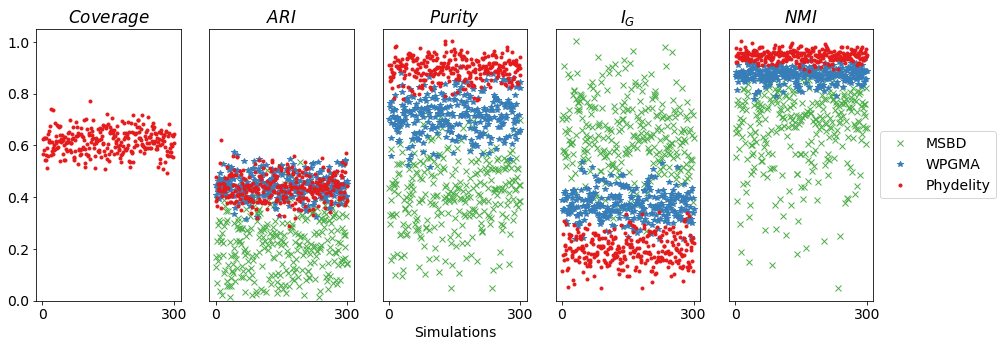

Network: C, Weight: 50%
Method [Mean(SD)]              Cov           ARI        Purity          Gini           NMI
Phydelity              61.2%(4.6%)    0.44(0.05)    0.82(0.03)    0.27(0.04)    0.86(0.02)
WPGMA                 100.0%(0.0%)    0.47(0.05)    0.68(0.06)    0.39(0.04)    0.81(0.02)
MSBD                  100.0%(0.0%)    0.22(0.10)    0.43(0.10)    0.59(0.09)    0.65(0.11)


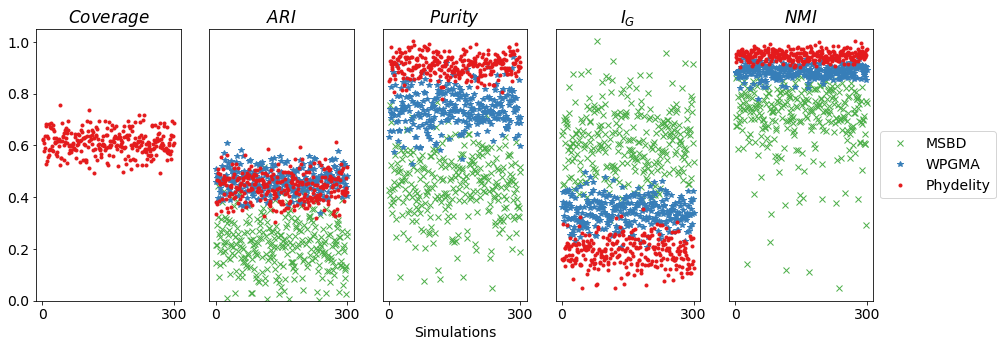

Network: C, Weight: 75%
Method [Mean(SD)]              Cov           ARI        Purity          Gini           NMI
Phydelity              59.4%(4.9%)    0.45(0.05)    0.85(0.03)    0.27(0.05)    0.86(0.02)
WPGMA                 100.0%(0.0%)    0.50(0.05)    0.71(0.06)    0.36(0.04)    0.82(0.02)
MSBD                  100.0%(0.0%)    0.20(0.09)    0.41(0.10)    0.61(0.10)    0.64(0.12)


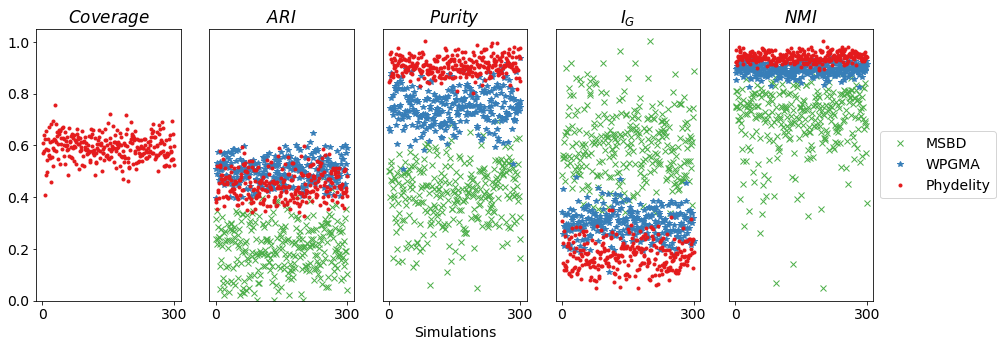

Network: C, Weight: 100%
Method [Mean(SD)]              Cov           ARI        Purity          Gini           NMI
Phydelity              58.2%(4.6%)    0.44(0.05)    0.88(0.03)    0.28(0.05)    0.86(0.02)
WPGMA                 100.0%(0.0%)    0.56(0.05)    0.74(0.06)    0.33(0.05)    0.83(0.02)
MSBD                  100.0%(0.0%)    0.19(0.09)    0.39(0.09)    0.62(0.09)    0.63(0.10)


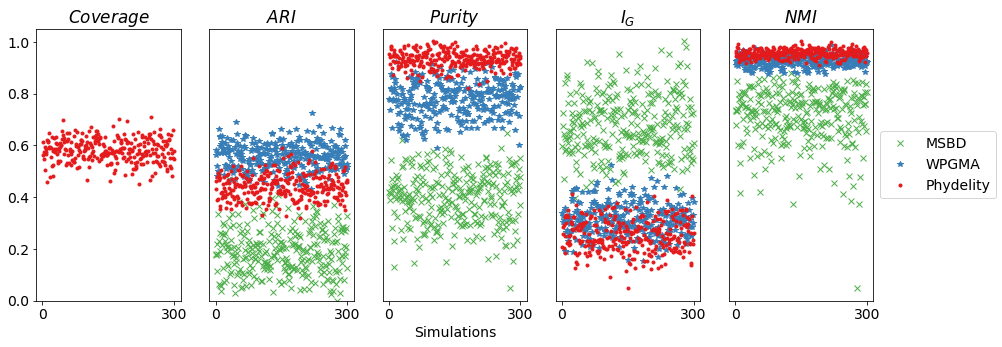

In [6]:
networks = ['C']
weight_indices = map(str, range(1,5))
sim_indices = map(str, range(1,301))
color_cycle = ['#e41a1c' , '#377eb8', '#4daf4a'] # phydelity, wpgma, msbd

matplotlib.rcParams.update({'font.size': 14})

for network in networks: 
    for weight_index in weight_indices:
        coverage = [fileindidces_to_phydelity_clustering_results[(network, weight_index, sim_index)][-1] for sim_index in sim_indices]
        
        phydelity_ari = [fileindidces_to_phydelity_clustering_results[(network, weight_index, sim_index)][0] for sim_index in sim_indices]
        msbd_ari = [fileindidces_to_msbd_clustering_results[(network, weight_index, sim_index)][0] for sim_index in sim_indices]
        wpgma_ari = [fileindidces_to_wpgma_clustering_results[(network, weight_index, sim_index)][0] for sim_index in sim_indices]
        
        phydelity_tpr = [fileindidces_to_phydelity_clustering_results[(network, weight_index, sim_index)][2] for sim_index in sim_indices]
        msbd_tpr = [fileindidces_to_msbd_clustering_results[(network, weight_index, sim_index)][2] for sim_index in sim_indices]
        wpgma_tpr = [fileindidces_to_wpgma_clustering_results[(network, weight_index, sim_index)][2] for sim_index in sim_indices]
        
        phydelity_gini = [fileindidces_to_phydelity_clustering_results[(network, weight_index, sim_index)][3] for sim_index in sim_indices]
        msbd_gini = [fileindidces_to_msbd_clustering_results[(network, weight_index, sim_index)][3] for sim_index in sim_indices]
        wpgma_gini = [fileindidces_to_wpgma_clustering_results[(network, weight_index, sim_index)][3] for sim_index in sim_indices]
        
        phydelity_nmi = [fileindidces_to_phydelity_clustering_results[(network, weight_index, sim_index)][1] for sim_index in sim_indices]
        msbd_nmi = [fileindidces_to_msbd_clustering_results[(network, weight_index, sim_index)][1] for sim_index in sim_indices]
        wpgma_nmi = [fileindidces_to_wpgma_clustering_results[(network, weight_index, sim_index)][1] for sim_index in sim_indices]
        
        
        print 'Network: {}, Weight: {:.0%}'.format(network, {1:0.25, 2:0.5, 3:0.75, 4:1.}[int(weight_index)])
        print '{:<20}{:>14}{:>14}{:>14}{:>14}{:>14}'.format('Method [Mean(SD)]', 'Cov', 'ARI', 'Purity', 'Gini', 'NMI')
        print '{:<20}{:>8.1%}({:<4.1%}){:>8.2f}({:>4.2f}){:>8.2f}({:>4.2f}){:>8.2f}({:>4.2f}){:>8.2f}({:>4.2f})'.format('Phydelity', np.mean(coverage),
                                                                                                      np.std(coverage),
                                                                                                      np.mean(phydelity_ari),
                                                                                                      np.std(phydelity_ari),
                                                                                                      np.mean(phydelity_tpr),
                                                                                                      np.std(phydelity_tpr),
                                                                                                      np.mean(phydelity_gini),
                                                                                                      np.std(phydelity_gini),
                                                                                                      np.mean(phydelity_nmi),
                                                                                                      np.std(phydelity_nmi))
        print '{:<20}{:>8.1%}({:<4.1%}){:>8.2f}({:>4.2f}){:>8.2f}({:>4.2f}){:>8.2f}({:>4.2f}){:>8.2f}({:>4.2f})'.format('WPGMA', 1.,
                                                                                                      0.,
                                                                                                      np.mean(wpgma_ari),
                                                                                                      np.std(wpgma_ari),
                                                                                                      np.mean(wpgma_tpr),
                                                                                                      np.std(wpgma_tpr),
                                                                                                      np.mean(wpgma_gini),
                                                                                                      np.std(wpgma_gini),
                                                                                                      np.mean(wpgma_nmi),
                                                                                                      np.std(wpgma_nmi))
        print '{:<20}{:>8.1%}({:<4.1%}){:>8.2f}({:>4.2f}){:>8.2f}({:>4.2f}){:>8.2f}({:>4.2f}){:>8.2f}({:>4.2f})'.format('MSBD', 1.,
                                                                                                      0.,
                                                                                                      np.mean(msbd_ari),
                                                                                                      np.std(msbd_ari),
                                                                                                      np.mean(msbd_tpr),
                                                                                                      np.std(msbd_tpr),
                                                                                                      np.mean(msbd_gini),
                                                                                                      np.std(msbd_gini),
                                                                                                      np.mean(msbd_nmi),
                                                                                                      np.std(msbd_nmi))
        
        f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15,5))
        x_interval = int(np.ceil(300/1))
        
        # plot coverage 
        ax1.plot(range(1, 301), coverage, ".", color=color_cycle[0])
        ax1.set_ylim(0, 1.05)
        ax1.set_yticks(np.arange(0, 1.05, 0.2))
        ax1.set_xticks(range(0, 301, x_interval))
        ax1.set_title("$Coverage$")
        
        ax2.plot(range(1, 301), msbd_ari, "x", label='MSBD', color=color_cycle[2])
        ax2.plot(range(1, 301), wpgma_ari, "*", label='WPGMA', color=color_cycle[1])
        ax2.plot(range(1, 301), phydelity_ari, ".", label='Phydelity', color=color_cycle[0])        
        
        ax2.set_ylim(0., 1.05)
        ax2.set_yticks([])
        ax2.set_xticks(range(0, 301, x_interval))
        ax2.set_title("$ARI$")
        
        ax3.plot(range(1, 301), msbd_tpr, "x", label='MSBD', color=color_cycle[2])
        ax3.plot(range(1, 301), wpgma_tpr, "*", label='WPGMA', color=color_cycle[1])
        ax3.plot(range(1, 301), phydelity_tpr, ".", label='Phydelity', color=color_cycle[0])
        
        y_max = np.ceil(np.max([np.max(phydelity_gini), np.max(wpgma_gini), np.max(msbd_gini)])+0.05)
        ax3.set_yticks([])
        ax3.set_xticks(range(0, 301, x_interval))
        ax3.set_xlabel('Simulations')
        ax3.set_title("$Purity$")
        
        ax4.plot(range(1, 301), msbd_gini, "x", label='MSBD', color=color_cycle[2])
        ax4.plot(range(1, 301), wpgma_gini, "*", label='WPGMA', color=color_cycle[1])
        ax4.plot(range(1, 301), phydelity_gini, ".", label='Phydelity', color=color_cycle[0])
        
        y_max = np.ceil(np.max([np.max(phydelity_gini), np.max(wpgma_gini), np.max(msbd_gini)])+0.05)
        ax4.set_yticks([])
        ax4.set_xticks(range(0, 301, x_interval))
        ax4.set_title("$I_G$")
        
        ax5.plot(range(1, 301), msbd_nmi, "x", label='MSBD', color=color_cycle[2])
        ax5.plot(range(1, 301), wpgma_nmi, "*", label='WPGMA', color=color_cycle[1])
        ax5.plot(range(1, 301), phydelity_nmi, ".", label='Phydelity', color=color_cycle[0])
        
        y_max = np.ceil(np.max([np.max(phydelity_gini), np.max(wpgma_gini), np.max(msbd_gini)])+0.05)
        ax5.set_yticks([])
        ax5.set_xticks(range(0, 301, x_interval))
        ax5.set_title("$NMI$")
        ax5.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
        f.savefig("{}_{}_stats.png".format(network, weight_index), bbox_inches='tight')
        plt.show()